In [10]:
import pandas as pd
import numpy as np

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt 

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (12, 8),
          'lines.linewidth': 3,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'boxplot.boxprops.linewidth':3.0,
          'boxplot.capprops.linewidth': 3.0,
          'boxplot.flierprops.linewidth': 3.0,
          'boxplot.medianprops.color': 'C0',
          'boxplot.medianprops.linestyle': '-',
          'boxplot.medianprops.linewidth': 3.0,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

In [11]:
# models tested 
models = ['RNN', 'MiRNN']

# levels of richness to sample 
n_trials = 5
richnesses = [5, 10, 15]

# specify species and metabolite names 
df_main = pd.read_csv("../Data/reactor_ubiome_sparsity.csv")
species = df_main.columns.values[2:-12]
metabolites =  []
controls = []
system_variables = np.concatenate((np.array(species), np.array(metabolites)))
system_variables

array(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20'],
      dtype=object)

In [27]:
df_main

,Experiments,Time,s1,s2,s3,s4,s5,s6,s7,s8,...,rf2,rf3,rf4,rf5,rf6,rf7,rf8,rf9,rf10,feed
0,Richness_5_0,0.0,0.010393,0.000000,0.000000,0.0,0.000000,0.000000,0.009889,0.000000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,Richness_5_0,26.0,0.147226,0.000000,0.000000,0.0,0.000000,0.000000,0.097496,0.000000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,Richness_5_0,52.0,0.304041,0.000000,0.000000,0.0,0.000000,0.000000,0.197555,0.000000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,Richness_5_0,78.0,0.250334,0.000000,0.000000,0.0,0.000000,0.000000,0.193828,0.000000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,Richness_5_0,104.0,0.221226,0.000000,0.000000,0.0,0.000000,0.000000,0.147685,0.000000,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Richness_15_149,26.0,0.066998,0.066948,0.051907,0.0,0.037732,0.047021,0.000000,0.051890,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
896,Richness_15_149,52.0,0.086376,0.079451,0.059121,0.0,0.041766,0.059172,0.000000,0.060808,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
897,Richness_15_149,78.0,0.078227,0.058031,0.052112,0.0,0.033834,0.048203,0.000000,0.054796,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
898,Richness_15_149,104.0,0.061190,0.053966,0.041454,0.0,0.028809,0.038395,0.000000,0.042612,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [24]:
# save dictionary with performance of each model 
performance_dict = {}

models = ["RNN", "MiRNN"]

for trial in range(n_trials):
    for richness in richnesses:
        for model in models:

            # import prediction dataframe
            df_kfold = pd.read_csv(f"Sparsity/{model}_richness_{richness}_trial_{trial}.csv")

            # prediction performances of species 
            s_rmse = 0
            for variable in species:
                y = []
                y_pred = []
                for exp_name, exp_df in df_kfold.groupby("Experiments"):
                    true_vals = exp_df[variable + " true"].values
                    pred_vals = exp_df[variable + " pred"].values
                    # append values if species was inoculated
                    if true_vals[0] > 0:
                        y.append(true_vals[1:])
                        y_pred.append(pred_vals[1:])
                s_rmse += np.sqrt(mse(np.concatenate(y), np.concatenate(y_pred))) / len(species)

            # store list of performances over each trial 
            performance_dict[f"{model} {richness} {trial} rmse"] = s_rmse

            # prediction performances of species 
            s_R = 0
            for variable in species:
                y = []
                y_pred = []
                for exp_name, exp_df in df_kfold.groupby("Experiments"):
                    true_vals = exp_df[variable + " true"].values
                    pred_vals = exp_df[variable + " pred"].values
                    # append values if the species was inoculated
                    if true_vals[0] > 0:
                        y.append(true_vals[1:])
                        y_pred.append(pred_vals[1:])
                s_R += linregress(np.concatenate(y), np.concatenate(y_pred)).rvalue / len(species)

            # store list of performances over each trial 
            performance_dict[f"{model} {richness} {trial} R"] = s_R

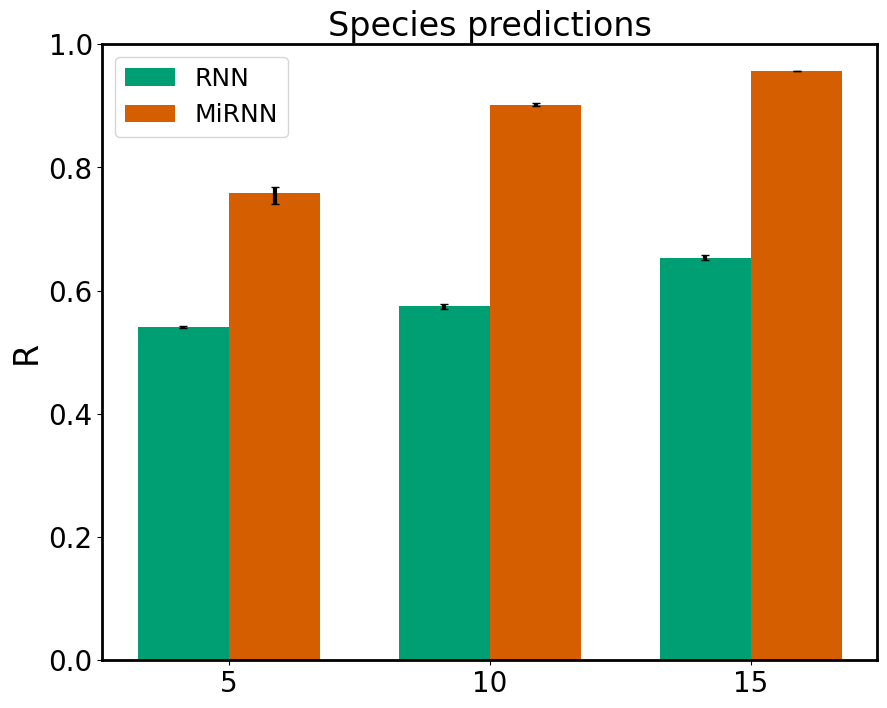

In [25]:
# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (10, 8),
          'lines.linewidth': 3,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':2,
          'boxplot.boxprops.linewidth':3.0,
          'boxplot.capprops.linewidth': 3.0,
          'boxplot.flierprops.linewidth': 3.0,
          'boxplot.medianprops.color': 'C0',
          'boxplot.medianprops.linestyle': '-',
          'boxplot.medianprops.linewidth': 3.0,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)

bar_heights = []
bar_errs = []
for model in models:
    heights = np.zeros(len(richnesses))
    errs = np.zeros([2, len(richnesses)])
    
    for i, richness in enumerate(richnesses):
        scores = [performance_dict[f"{model} {richness} {trial} R"] 
                  for trial in range(n_trials)]
        middle = np.median(scores)
        heights[i] = middle
        quantiles = np.quantile(scores, [.25, .75])
        errs[:, i] = [middle-quantiles[0], quantiles[-1]-middle]

    bar_heights.append(heights)
    bar_errs.append(errs)
        
# set plot parameters
fig, ax = plt.subplots()

width = 0.35
x = np.arange(len(richnesses))
ax.bar(x - .5 * width, bar_heights[0], width, label=models[0], yerr=bar_errs[0], capsize=3, color='C1')
ax.bar(x + .5 * width, bar_heights[1], width, label=models[1], yerr=bar_errs[1], capsize=3, color='C2')

ax.set_xticks(x)
ax.set_xticklabels(richnesses)
ax.set_ylim([0, 1])

plt.legend()
plt.ylabel(r"R")
plt.title("Species predictions")
plt.savefig("RNN_sparsity_R_comparison.pdf", dpi=300)
plt.show()

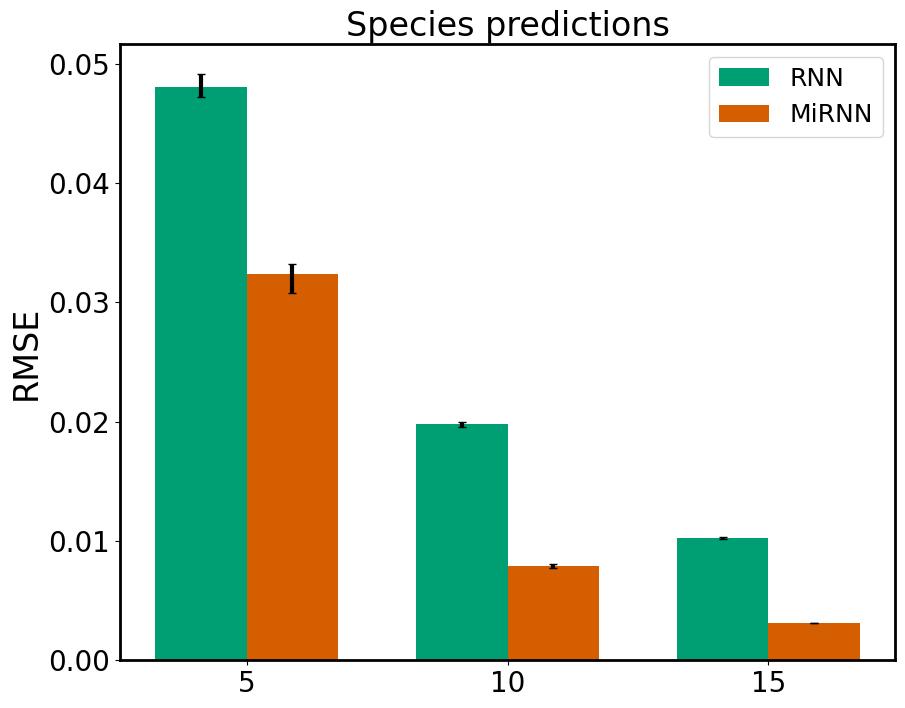

In [26]:
# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (10, 8),
          'lines.linewidth': 3,
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':2,
          'boxplot.boxprops.linewidth':3.0,
          'boxplot.capprops.linewidth': 3.0,
          'boxplot.flierprops.linewidth': 3.0,
          'boxplot.medianprops.color': 'C0',
          'boxplot.medianprops.linestyle': '-',
          'boxplot.medianprops.linewidth': 3.0,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)

bar_heights = []
bar_errs = []
for model in models:
    heights = np.zeros(len(richnesses))
    errs = np.zeros([2, len(richnesses)])
    
    for i, richness in enumerate(richnesses):
        scores = [performance_dict[f"{model} {richness} {trial} rmse"] 
                  for trial in range(n_trials)]
        middle = np.median(scores)
        heights[i] = middle
        quantiles = np.quantile(scores, [.25, .75])
        errs[:, i] = [middle-quantiles[0], quantiles[-1]-middle]

    bar_heights.append(heights)
    bar_errs.append(errs)
        
# set plot parameters
fig, ax = plt.subplots()

width = 0.35
x = np.arange(len(richnesses))
ax.bar(x - .5 * width, bar_heights[0], width, label=models[0], yerr=bar_errs[0], capsize=3, color='C1')
ax.bar(x + .5 * width, bar_heights[1], width, label=models[1], yerr=bar_errs[1], capsize=3, color='C2')

ax.set_xticks(x)
ax.set_xticklabels(richnesses)
# ax.set_ylim([0, 1])

plt.legend()
plt.ylabel(r"RMSE")
plt.title("Species predictions")
plt.savefig("RNN_sparsity_rmse_comparison.pdf", dpi=300)
plt.show()